## dump notebook for quick testing of modules

In [62]:
%matplotlib notebook

from forced_barotropic_sphere.sphere import Sphere
from forced_barotropic_sphere.solver import Solver
from forced_barotropic_sphere.forcing import Forcing
import forced_barotropic_sphere.parcel_tracking as tracking
import forced_barotropic_sphere.plotting as plotters
import forced_barotropic_sphere.ensemble_methods as ensemble_methods


import numpy as np
import xarray as xr
import random
import matplotlib.pyplot as plt
import matplotlib as mpl          # Plotting routines
import matplotlib.pyplot as plt    
import matplotlib.animation as manim
import matplotlib.ticker as mticker
from IPython.display import display, clear_output, HTML, FileLink  # Some technical stuff, used to display animation
#from ipywidgets import FloatProgress
from ipykernel.pylab.backend_inline import flush_figures
import cartopy                   # Map projection stuff
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import cython_routines.bm_methods as bm
import seaborn as sns

In [63]:
##physical constants
s2d = 1/3600/24    # seconds to days
s2h = 1/3600       # seconds to hours
a = 6371e3         # Radius of the earth in m
g00 = 9.81         # Acceleration due to gravity near the surface of the earth in m/s^2
R = 287.           # Dry gas constant in J/K/kg
d2r = np.pi / 180. # Factor to convert degrees to radians
r2d = 180. / np.pi # Factor to convert radians to degrees


In [64]:
num_members= 10 #num of members in the ensemble
dt = 4000 #time between integration steps (seconds)
Nt = 300 #number of integration steps
T= Nt*dt #total integration time

print('integrating for {:.1f} days with a dt of {:.2f} hours'.format(T*s2d,dt*s2h))

ofreq = 6 #frequency of integration output in resulting ds
print('output freq of {:.2f} hours'.format(dt*s2h*ofreq))

ofreq = 6

#T42 resolution
nlat=64; nlon=128

thetap = np.zeros((nlat,nlon))
vortp = np.zeros((nlat,nlon))
ics = np.array([vortp,thetap])

ensemble = ensemble_methods.integrate_ensemble(nlat,nlon,dt=dt, T=T, ofreq=ofreq, ics=ics,
                                                n_ens=num_members, temp_linear=True,
                                               vort_linear=True)
ensemble=ensemble.assign_coords(ens_mem= range(len(ensemble.ens_mem)))
tidx=int(Nt/ofreq)-1

# f,axs=plotters.plot_ensemble_overview(ensemble.isel(time=tidx), perturbation=[True,False],
#                                       levels=[np.linspace(-1,1,6),np.arange(258,300,7),None])


integrating for 13.9 days with a dt of 1.11 hours
output freq of 6.67 hours


100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.13it/s]


In [65]:
dsr = ensemble.rename(dict(x='lon',y='lat'))
# Reassign longitude coordinates between -180 and 180E
dsr = dsr.assign_coords(lon=(((dsr.lon + 180) % 360) - 180))
dsr = dsr.sortby('lon')
dsr=dsr.reindex(lat=list(reversed(dsr.lat)))

#x0 should be in form [(lon,lat),]
std = dsr.theta.std('ens_mem').sel(lat=slice(30,90))
sm = std.where(std==std.max(), drop=True).squeeze()
x0 = [(sm.lon.item(0),sm.lat.item(0))]

ts, xs = tracking.ens_calculate_trajectories(dsr, x0, t0 = float(T), rvs=True)


Integrating 1 trajectories for [13.88888889].


100%|█████████████████████████████████████████| 249/249 [03:44<00:00,  1.11it/s]

Completed 250 of 250 timesteps.


In [148]:
from matplotlib.collections import LineCollection

#+++Plotting routines for ensembles+++#
def plot_theta_ensspread(ds,t, levels=np.arange(0,10,2), trjs=None,ts=None, proj = ccrs.NorthPolarStereo()):
    """
    Plot ensemble spread (defined as 1 std of ensemble) of theta
    """
    f = plt.figure(figsize = (5, 5))
    ax = plt.axes(projection=proj)
    ax.set_extent([-179.9, 179.9, 20, 90], crs=ccrs.PlateCarree())
    plotters.make_ax_circular(ax)
    
    ds=xr.concat([ds, ds.isel(lon=slice(0,1)).assign_coords(lon=[180])], dim='lon')
    background = ds.theta.sel(ens_mem=0).sel(time=0)
    theta = ds.theta.std('ens_mem').sel(time=t)
    
    #use to get colorbar
    cm = sns.color_palette("light:seagreen", as_cmap=True)
    normcm = mpl.colors.BoundaryNorm(levels, cm.N)

    cf=ax.contourf(theta.lon.data, theta.lat.data, theta.data, transform = ccrs.PlateCarree(), 
            levels=levels,cmap=cm, norm=normcm)
    
    plt.colorbar(cf, ax=ax, label='Std(Temp) (K)',shrink=0.8)
    
    btlev= np.arange(260,310,10)
    norm = plt.Normalize(btlev[0], btlev[-1])
    cmap = plt.cm.coolwarm
    
    ax.contour(background.lon.data, background.lat.data, background.data,
          cmap=cmap, levels=btlev, transform=ccrs.PlateCarree(),zorder=10, alpha=0.75, linestyles='--')
    
    ax.text(0.5, -0.1, 't = {:.2f} days'.format(theta.time.item(0)/86400), horizontalalignment='center',
         verticalalignment='top', transform=ax.transAxes)
    
    if trjs is not None:
        ntr = trjs.shape[2]
        for i in range(ntr):
            #start point
            
            txs = trjs[:,0,i]
            tys = trjs[:,1,i]
            
            scol = ds.theta.sel(ens_mem=i).interp(time=0, lon=txs[-1],lat=tys[-1]).item(0)
            ax.scatter(trjs[-1, 0, i], trjs[-1, 1, i], c= scol, norm=norm,cmap=cmap, marker='o',
                      transform=ccrs.PlateCarree(), zorder=10)
            
            
            #locations for ploting
            xsc = xr.DataArray(txs.reshape(-1), dims=['location'])
            ysc = xr.DataArray(tys.reshape(-1), dims=['location'])
            tsc = xr.DataArray(ts[:,i].reshape(-1), dims=['location'])
            cols = ds.theta.sel(ens_mem=i).interp(time=tsc,lon=xsc,lat=ysc).values

            points = np.array([sanitize_lonlist(txs), tys]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            
            lc = LineCollection(segments, cmap=cmap,norm=norm, transform=ccrs.PlateCarree())
            lc.set_array(cols)
            lc.set_linewidth(2)
            line = ax.add_collection(lc)
            
            ax.plot(trjs[0:1, 0, i], trjs[0:1, 1, i], 'kx', ls='', mew=2., transform=ccrs.PlateCarree(), zorder=20) #final point
            #ax.plot(trjs[50::50, 0, i], trjs[50::50, 1, i], 'k+', ls='', mew=1.)
            
    return ax

<IPython.core.display.Javascript object>


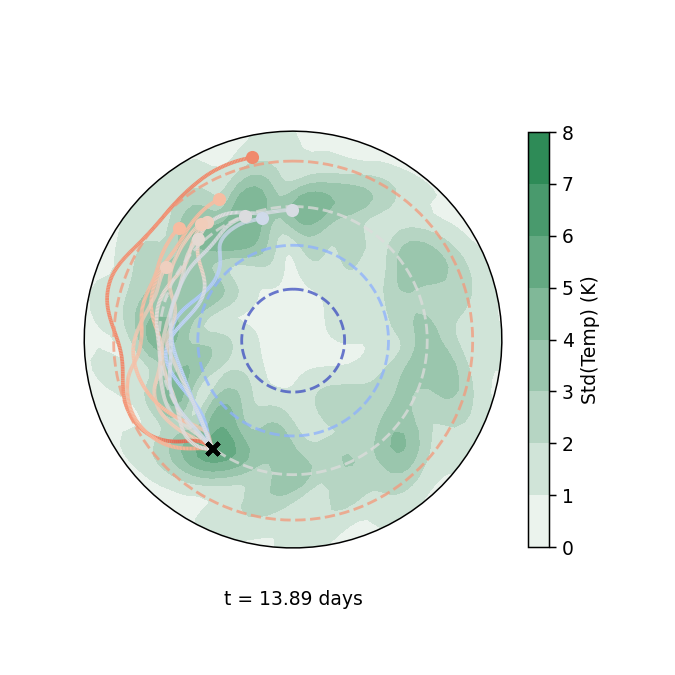

<GeoAxesSubplot:>

In [149]:
plot_theta_ensspread(dsr,t=T,trjs=xs,ts=ts, levels=np.arange(0,9,1))

In [44]:
ts.shape

(80, 10, 1)

In [45]:
xs.shape

(80, 2, 10, 1)